# This is the production version of the ROI processing for FCN training


the method is to run all the patients folders where there is a xxx.txt file, and to create the ROI mask for this and store under.png file format

Various plotting schemes are shown so to validate the data

To split the dataset into validation and test set, run also the last 2 cells.

the manual one is to do all step but not the one "start processing - Scripted"

Updated : April 29, 2017

## creates 455 sample images with ROI inside


# more details

FCN training requires images 512x512 being formatted as .bmp files together with annotation data (ROI data) formatted as .png files.

Then a random split between training validation and test set is run at the very end so we end up with a populated directory structure as required.

NOTE: only slices with ROI information are used. If this is really correct is yet to be determined. Issues like balanced datasets can not be detailed at this point. However it is already clear that areas without any annotation should be declared "healthy" and these areas will be dramatically more present than areas with annotation.

Also unclear is if the training will use special coding for area outside lung. That is to say the initial lung segmentation run will issue all "ouside" lung areas a -1024 (or to be determined).

     Hence, in this spirit of kowledge, lte's start



In [1]:
from PIL import Image
from __future__ import print_function
from matplotlib.pyplot import imshow
import numpy as np


from pylab import *
from PIL import Image, ImageDraw
from scipy import misc

import cv2
import time
import os
import sys
import shutil

import dicom
import scipy as sp
from scipy import ndimage
import skimage
from skimage import measure
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#%matplotlib inline

import tensorflow as tf
import TensorflowUtils as utils
from tensorflow.python.platform import gfile
import TensorflowUtils as utils

import datetime
import BatchDatsetReader as dataset
from six.moves import xrange
from six.moves import cPickle as pickle

import random
import glob
import cv2


print ("completed imports")
print ("versions used")
print ("tensorflow           :  ", tf.__version__)
print ("numpy                :  ", np.__version__)
print ("")

completed imports
versions used
tensorflow           :   1.1.0
numpy                :   1.12.1



All utilities that we may use are in the helpers.py file 

In [2]:
sys.path.append('/Users/peterhirt/datascience/utilities')  
import helpers as H 

### prevents scroll formatting of very long output data

In [4]:
%matplotlib notebook
import mpld3
mpld3.enable_notebook()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))



# preparation of directories etc....
    
    patients_path             : Absolute path to patients folders
    ROI_destination_path      : folder attached to absolute individual patient path
    file_preamble             : file name part that will be used to prefix all files generated
    
    PID                       : patient ID
    list_patients_dir_sorted  :  list with all patient folders to be processed
    text_file                 :  file where the ROI information is stored
    
hence a image file for training could then be 

/Users/peterhirt/datascience/ild-cnn/HUG/ILD_DB_txtROIs/HUGdata/images/training/patient_23_06.bmp

In [5]:
patients_path = '/Users/peterhirt/datascience/ild-cnn/HUG/ILD_DB_txtROIs'
ROI_mask_destination_folder = 'HUGdataJul4'
file_preamble = '/patient_'

list_patients_dir_sorted = []

# generate a list of patients to process
list_patients_dir = (os.listdir(patients_path))

for i in range(185):
    if str(i) in list_patients_dir:
        list_patients_dir_sorted.append(i)

print("List of all Patient folders")
print("===========================")
print (list_patients_dir_sorted)




List of all Patient folders
[3, 7, 8, 12, 17, 19, 21, 23, 34, 35, 36, 37, 38, 39, 41, 45, 46, 47, 48, 51, 53, 56, 57, 62, 65, 66, 70, 74, 76, 77, 78, 80, 81, 82, 83, 84, 89, 90, 92, 94, 101, 105, 107, 108, 109, 112, 116, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 140, 142, 143, 144, 147, 149, 150, 152, 153, 154, 155, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 177, 179, 180, 181, 182, 183, 184]


# Create Directory structure for results

ATTENTION: removes all existing data in these folders

In [6]:
def remove_folder(path):
    """ function to remove folder """
    if os.path.exists(path):
         shutil.rmtree(path)

In [7]:
def color_image(image, num_classes=20):
    import matplotlib as mpl
    import matplotlib.cm
    norm = mpl.colors.Normalize(vmin=0., vmax=num_classes)
    mycm = mpl.cm.get_cmap('Set3')
    return mycm(norm(image))

In [20]:
def predict_and_display(valid_images, valid_annotations, NUM_OF_CLASSESS, label_names, image_file):
    
    unique, counts = np.unique(valid_annotations, return_counts=True)
    for n in range(len(unique)):
        
        print(unique[n], "\t", counts[n], "\t", label_names[unique[n]+1])
        
    label_title = label_names[unique[n]+1]
    
    xx = image_file.split('_')
    xx[2]

    slice_number = xx[2].split('.')
    slice_number[0]
    
    fig = plt.figure()
    fig.set_size_inches(18, 7)
    fig.suptitle("slice" + slice_number[0])

    patch = fig.add_subplot(1,3,1)
    patch.axes.get_xaxis().set_visible(False)
    patch.axes.get_yaxis().set_visible(False)
    patch.imshow(valid_images[0]);


    new_image = color_image(valid_annotations[0], NUM_OF_CLASSESS)
    patch = fig.add_subplot(1,3,2)
    patch.axes.get_xaxis().set_visible(False)
    patch.axes.get_yaxis().set_visible(False)
    patch.axes.set_title(label_title)
    patch.imshow(new_image);
    
    patch = fig.add_subplot(1,3,3)
    patch.axes.get_xaxis().set_visible(False)
    patch.axes.get_yaxis().set_visible(False)
    patch.imshow(valid_images[0]);
    masked_imclass = np.ma.masked_where(new_image == 0, new_image)
    plt.imshow( masked_imclass, alpha=0.5 )  

In [9]:
def process_image_list(image_list, print_enable):

    images_processed = []

    for it in image_list:
        if print_enable:
            print ('slice : ',it)
        print ('numbers of ROIs in slice {}: {}'.format(it, len(image_list[it])))
        new_img = Image.new("L", [512,512], color=0)

        for n in range(len(image_list[it])):
            keys = list(image_list[it][n].keys())
            if print_enable:
                print('next ROI has type of class : ', keys[0])
            #print(image_list[it][n])


            if str(keys[0]) == "reticulation":
                colorCode = 3
                big_roi = image_list[it][n]['reticulation']

            if str(keys[0]) == "peripheral_micronodules":
                colorCode = 11
                big_roi = image_list[it][n]['peripheral_micronodules']

            if str(keys[0]) == "pcp":
                colorCode = 2
                big_roi = image_list[it][n]['pcp']

            if str(keys[0]) == "increased_attenuation":
                colorCode = 4
                big_roi = image_list[it][n]['increased_attenuation']

            if str(keys[0]) == "macronodules":
                colorCode = 5
                big_roi = image_list[it][n]['macronodules']

            if str(keys[0]) == "micronodules":
                colorCode = 6
                big_roi = image_list[it][n]['micronodules']

            if str(keys[0]) == "ground_glass":
                colorCode = 7
                big_roi = image_list[it][n]['ground_glass']

            if str(keys[0]) == "fibrosis":
                colorCode = 8
                big_roi = image_list[it][n]['fibrosis']

            if str(keys[0]) == "bronchiectasis":
                colorCode = 9
                big_roi = image_list[it][n]['bronchiectasis']

            if str(keys[0]) == "emphysema":
                colorCode = 10
                big_roi = image_list[it][n]['emphysema']

            if str(keys[0]) == "healthy":
                colorCode = 1
                big_roi = image_list[it][n]['healthy']
            
            if str(keys[0]) == "consolidation":
                colorCode = 12
                big_roi = image_list[it][n]['consolidation']
                
            if str(keys[0]) == "air_trapping":
                colorCode = 13
                big_roi = image_list[it][n]['air_trapping']
                
            if str(keys[0]) == "early_fibrosis":
                colorCode = 14
                big_roi = image_list[it][n]['early_fibrosis']


            draw = ImageDraw.Draw(new_img)
            draw.polygon(big_roi, fill = colorCode)

        del draw

        im_arr2 = np.asarray(new_img)
        images_processed.append(im_arr2)


        if it < 10:
            file_name = training_dir1 + file_preamble + str(PID) + '_' + '0' + str(it) + '.png'
        else:
            file_name = training_dir1 + file_preamble + str(PID) + '_' + str(it) + '.png'

        misc.imsave(file_name, im_arr2)

        #
        #  save also the correspoding image  file 
        #

        display_min = 0
        display_max = 4096
        count = 0

        dicom_files = [f for f in os.listdir(patient_dir) if f.endswith('.dcm')]
        if len(dicom_files) > 0:
            for f in dicom_files:

                dicom_file_URL = os.path.join(patient_dir, f)

                RefDs = dicom.read_file(dicom_file_URL) 
                dsr = RefDs.pixel_array
                dataf = dsr.astype(float)
                np.clip(dataf, display_min, display_max, out=dataf)
                dataf -= display_min
                datab = ((255. / (display_max - display_min)) * dataf).astype(np.uint8)

                img = Image.fromarray(datab)

                sliceNumber = int(RefDs.InstanceNumber)

                # check if processed Slice has an annotation or not
                if sliceNumber in annotated_slice_list:
                    if sliceNumber < 10:
                        file_name = training_dir + file_preamble + str(PID) + '_' +'0' + str(sliceNumber) + '.jpg'
                    else:
                        file_name = training_dir + file_preamble + str(PID) + '_'  + str(sliceNumber) + '.jpg'

                    img.save(file_name)

    
    return images_processed


# Start

# start processing - Scripted

In [10]:
print(patients_path)
HUGdata_dir = os.path.join(patients_path, ROI_mask_destination_folder) 
remove_folder(HUGdata_dir)
print (HUGdata_dir)
if not os.path.exists(HUGdata_dir):
    os.makedirs(HUGdata_dir)

images_dir = os.path.join(HUGdata_dir, 'images') 
print (images_dir)
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
    
training_dir = os.path.join(images_dir, 'training') 
print (training_dir)
if not os.path.exists(training_dir):
    os.makedirs(training_dir)

validation_dir = os.path.join(images_dir, 'validation') 
print (validation_dir)
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)
    
annotations_dir = os.path.join(HUGdata_dir, 'annotations') 
print (annotations_dir)
if not os.path.exists(annotations_dir):
    os.makedirs(annotations_dir)
    
training_dir1 = os.path.join(annotations_dir, 'training') 
print (training_dir1)
if not os.path.exists(training_dir1):
    os.makedirs(training_dir1)

validation_dir1 = os.path.join(annotations_dir, 'validation') 
print (validation_dir1)
if not os.path.exists(validation_dir1):
    os.makedirs(validation_dir1)



/Users/peterhirt/datascience/ild-cnn/HUG/ILD_DB_txtROIs
/Users/peterhirt/datascience/ild-cnn/HUG/ILD_DB_txtROIs/HUGdataJul4
/Users/peterhirt/datascience/ild-cnn/HUG/ILD_DB_txtROIs/HUGdataJul4/images
/Users/peterhirt/datascience/ild-cnn/HUG/ILD_DB_txtROIs/HUGdataJul4/images/training
/Users/peterhirt/datascience/ild-cnn/HUG/ILD_DB_txtROIs/HUGdataJul4/images/validation
/Users/peterhirt/datascience/ild-cnn/HUG/ILD_DB_txtROIs/HUGdataJul4/annotations
/Users/peterhirt/datascience/ild-cnn/HUG/ILD_DB_txtROIs/HUGdataJul4/annotations/training
/Users/peterhirt/datascience/ild-cnn/HUG/ILD_DB_txtROIs/HUGdataJul4/annotations/validation


added that the generated image is appended to the images_processed list which is then used to display the images for control if everything is done correctly

In [11]:
#list_patients_dir_handpicked = [3, 7, 12, 17, 21, 23, 34, 35, 36, 45, 46, 47, 48, 56, 62, 65, 66, 70, 74, 76, 77, 78, 80, 82, 83, 84, 89, 90, 92, 94]
#list_patients_dir_handpicked = [101, 105, 107, 108,  109, 112, 116, 119, 120, 121, 123, 124, 126, 127, 128, 130, 131, 132, 134, 135, 136, 137, 138, 140, 143, 144, 147, 149, 150, 152, 153, 155, 157, 159, 160, 163, 165, 166, 167, 168, 169, 171]
#list_patients_dir_handpicked = [173, 174, 175, 177, 179, 181, 182, 183, 185]

# list of all patients
#list_patients_dir_handpicked = [3, 7, 12, 17, 19, 21, 23, 34, 35, 36, 45, 46, 47, 48, 51, 56, 62, 65, 66, 70, 74, 76, 77, 78, 80, 82, 83, 84, 89, 90, 92, 94, 101, 105, 107, 108,  109, 112, 116, 119, 120, 121, 123, 124, 126, 127, 128, 130, 131, 132, 134, 135, 136, 137, 138, 140, 143, 144, 147, 149, 152, 153, 155, 157, 159, 160, 163, 165, 166, 167, 168, 169, 171, 173, 174, 175, 177, 179, 181, 182, 183, 185]
#list_patients_dir_handpicked = [150, 152, 153, 155, 157, 159, 160, 163, 165, 166, 167, 168, 169, 171, 173, 174, 175, 177, 179, 181, 182, 183, 185]

#list_patients_dir_handpicked = [127]

#list_patients_dir_handpicked = [3,7,17,35,36,45,46,47,48,56,62,66,70,74,76,77,78,80]
#list_patients_dir_handpicked = [82,83,84,89,90,92,94,105,107,108,109,112,116,119,120,121,123,124,126,127,130,131,134,135,136]
#list_patients_dir_handpicked = [137,140,143,144,147,149,150,152,153,155,157,159, 160,163,165,166,168,171]
#list_patients_dir_handpicked = []

list_patients_dir_handpicked = [17]

# flow
     1. go thru patient list
     2. find .txt file with ROI information
     3. parse .txt file
         - line per line
         - print annotated slice list and length of image_list
         - call function process_image_list()
             o for each image(or slice), create a empty image
             o for each ROI draw on top of this image and place the colour code where appropriate
             o append to images_processed
             o save image as .png file
             o look for corresponding Dicom file and save it under .bmp

In [12]:
print_enable = False
count_images = 0

if len(list_patients_dir_handpicked) > 0 :
    processed_patients_list = list_patients_dir_handpicked
else:
    processed_patients_list = list_patients_dir_sorted
    
for PID in processed_patients_list:
    print('Patient : ', PID)
    patient_dir =  os.path.join(patients_path, str(PID))
    listscanfile = [name for name in os.listdir(patient_dir) if name.lower().find('.dcm', 0) > 0]
    textfiles_array = [name for name in os.listdir(patient_dir) if name.find('.txt') > 0]
    if len(textfiles_array) > 1:
        print("more than one text file present, please check data directory of patient!")
    else:
        text_file = textfiles_array[0]
        if print_enable:
            print (text_file)
    ROI_file_URL = os.path.join(patient_dir, text_file)
    if print_enable:
        print(ROI_file_URL)

    lines = [line.rstrip('\n') for line in open(ROI_file_URL)]
 
    contours = 0
    counter = 0
    annotated_slice_list = []
    image_list = {}
    start_from_zero = True
    slice_duplicate = False
    
    for line in lines:
        if "SpacingX" in line:
            PIXEL_SPACING = float(line.split(': ')[-1])
        if "label" in line:
            label = line.split(': ')[-1]
            if print_enable:
                print ("###############################################")
                print ("label : ", label)
                    
        if "slice_number" in line: 
            
            slice_number = int(line.split(': ')[-1])
            if print_enable:
                print ("-----------------------------------------------")
                print ("processing slice number : ", slice_number)
                
            # annotated_slice_list.append(slice_number)
            if start_from_zero:
                annotated_slice_list.append(slice_number)
                image_list[slice_number] = []
                start_from_zero = False
                #print('first time',image_list)
            else:
                #print('next times')
                for k in range(len(annotated_slice_list)):
                    #print('slice in annotation file', annotated_slice_list[k])
                    if annotated_slice_list[k] == slice_number:
                        slice_duplicate = True
                        
                if not slice_duplicate:       
                    annotated_slice_list.append(slice_number)
                    image_list[slice_number] = []
                    
                slice_duplicate = False
  
        if "nb_points_on_contour" in line:
            #if print_enable:
            #    print('label', label)
            idx = lines.index(line)

            # get the number of contours and create the big_roi list
            contours = line.split(': ')[-1]
            counter = int(contours)
            if print_enable:
                print ("processing contour  : ", counter)

            big_roi = []
            lineSplitFloat = [0.0, 0.0]

            # create the list with all coordinates for one single ROI
            for i in range(counter):
                j = i + idx + 1
                lineSplit = lines[j].split()

                lineSplitFloat[0] = float16(lineSplit[0])/PIXEL_SPACING 
                lineSplitFloat[1] = float16(lineSplit[1])/PIXEL_SPACING 
                coordinate = (tuple(lineSplitFloat))

                big_roi.insert(j, coordinate)
            
            record = {}
            record[label] = big_roi
            
            image_list[slice_number].append(record)
            #print(slice_number, image_list[slice_number][-1])
            
    if print_enable:
        print(annotated_slice_list) 
    if print_enable:
        print ("image list : ", len(image_list))
    images_processed = process_image_list(image_list, print_enable)

Patient :  17
numbers of ROIs in slice 6: 1
numbers of ROIs in slice 7: 1
numbers of ROIs in slice 8: 2
numbers of ROIs in slice 9: 4
numbers of ROIs in slice 10: 6
numbers of ROIs in slice 11: 3
numbers of ROIs in slice 12: 1
numbers of ROIs in slice 13: 1
numbers of ROIs in slice 14: 1
numbers of ROIs in slice 15: 3
numbers of ROIs in slice 16: 1
numbers of ROIs in slice 17: 4
numbers of ROIs in slice 18: 3
numbers of ROIs in slice 19: 2
numbers of ROIs in slice 20: 1
numbers of ROIs in slice 21: 2
numbers of ROIs in slice 22: 2
numbers of ROIs in slice 23: 1


In [13]:
len(images_processed)

18

In [14]:
list_images = os.listdir(training_dir)
list_images[:]

['patient_17_06.jpg',
 'patient_17_07.jpg',
 'patient_17_08.jpg',
 'patient_17_09.jpg',
 'patient_17_10.jpg',
 'patient_17_11.jpg',
 'patient_17_12.jpg',
 'patient_17_13.jpg',
 'patient_17_14.jpg',
 'patient_17_15.jpg',
 'patient_17_16.jpg',
 'patient_17_17.jpg',
 'patient_17_18.jpg',
 'patient_17_19.jpg',
 'patient_17_20.jpg',
 'patient_17_21.jpg',
 'patient_17_22.jpg',
 'patient_17_23.jpg']

In [15]:
list_annotations = os.listdir(training_dir1)
list_annotations[:]

['patient_17_06.png',
 'patient_17_07.png',
 'patient_17_08.png',
 'patient_17_09.png',
 'patient_17_10.png',
 'patient_17_11.png',
 'patient_17_12.png',
 'patient_17_13.png',
 'patient_17_14.png',
 'patient_17_15.png',
 'patient_17_16.png',
 'patient_17_17.png',
 'patient_17_18.png',
 'patient_17_19.png',
 'patient_17_20.png',
 'patient_17_21.png',
 'patient_17_22.png',
 'patient_17_23.png']

# check
reading again the png file and see if things are still the same

In [16]:
NUM_OF_CLASSESS = 11

label_names = ["background","healthy","consolidation","pcp","reticulation","increased_attenuation","macronodules","micronodules",
              "ground_glass","fibrosis", "bronchiectasis","emphysema","peripheral_micronodules","consolidation","air_trapping","early_fibrosis"]


slice 10 ------------------------
0 	 260611 	 healthy
10 	 1533 	 emphysema


<IPython.core.display.Javascript object>


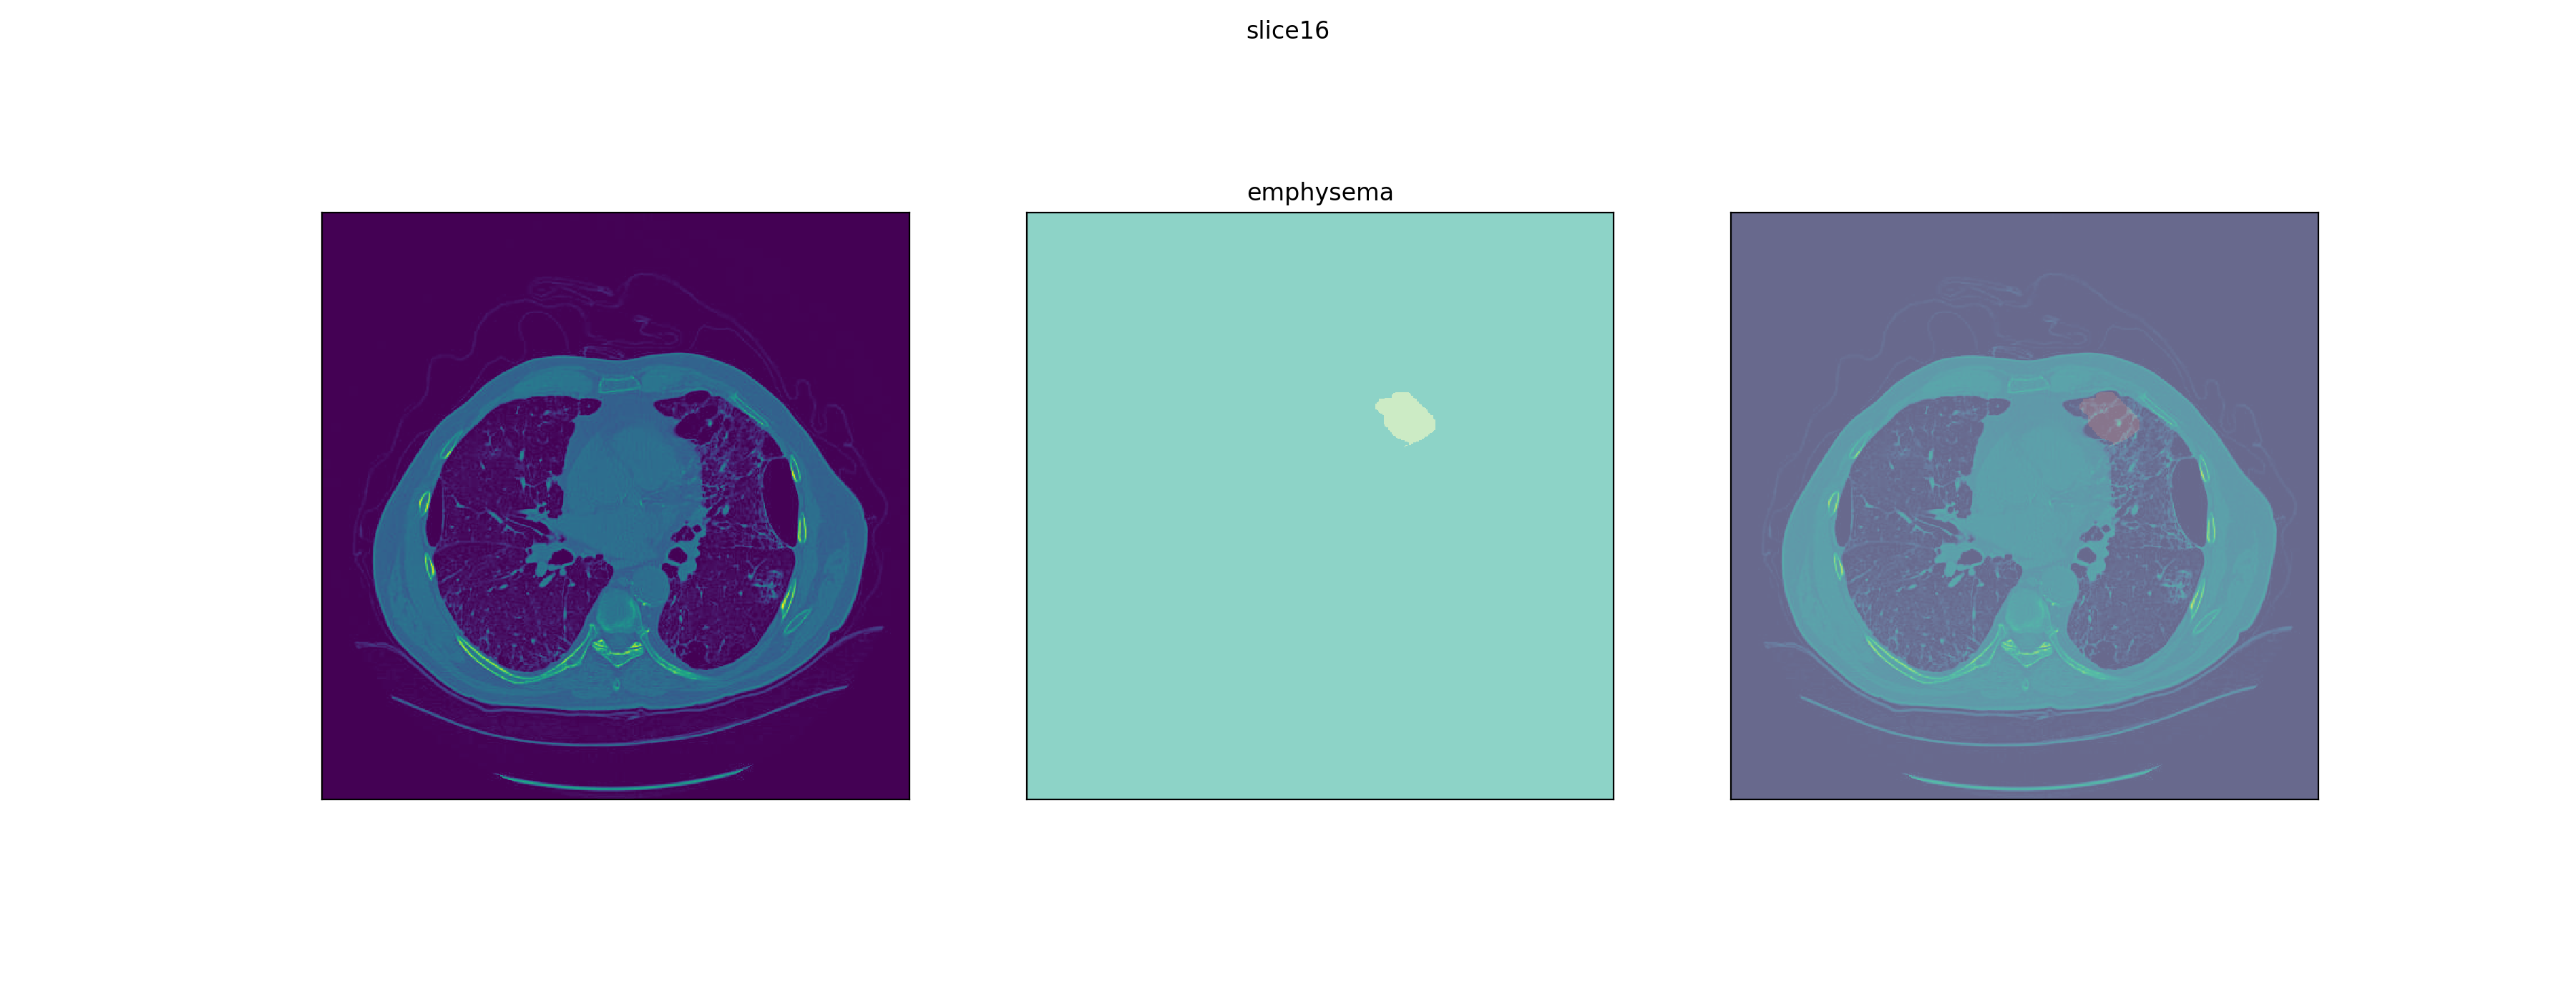

In [25]:
j = 10


image_file = list_images[j]
label_file = list_annotations[j]

png_file = Image.open(training_dir1 + '/' + label_file)
bmp_file = Image.open(training_dir + '/' + image_file)

image = np.asarray(bmp_file)
label = np.asarray(png_file)

print("slice {} ------------------------".format(j))   
predict_and_display(np.expand_dims(image, axis=0), np.expand_dims(label, axis=0), NUM_OF_CLASSESS, label_names, image_file)
       

In [ ]:

for j in xrange(len(list_images)):
    
    image_file = list_images[j]
    label_file = list_annotations[j]

    png_file = Image.open(training_dir1 + '/' + label_file)
    bmp_file = Image.open(training_dir + '/' + image_file)

    image = np.asarray(bmp_file)
    label = np.asarray(png_file)
    
    print("slice {} ------------------------".format(j))   
    predict_and_display(np.expand_dims(image, axis=0), np.expand_dims(label, axis=0), NUM_OF_CLASSESS, label_names, image_file)
       

In [103]:
x = list_images[0]
x

xx = x.split('_')
xx[2]

slice_number = xx[2].split('.')
slice_number[0]

#slice_number = int(list_images[0].split('.')[-1])

'03'

# random validation set creation

In [ ]:
images = [f for f in os.listdir(training_dir) if f.endswith('.jpg')]
print ('image files\t \t: {}'.format(len(images)))
annotations = [f for f in os.listdir(training_dir1) if f.endswith('.png')]
print ('annotation files\t: {}'.format(len(annotations)))

In [ ]:
# SET percentage of validation / training set
validation_set = 0.05

total_images_list = os.listdir(training_dir)
number_of_images = len(total_images_list)
number_images_validation_set = int(number_of_images * validation_set)

print ("total number of images ", number_of_images, "and", number_images_validation_set , "images in validation set ")

for sample in xrange(number_images_validation_set):
    
    total_images_list = os.listdir(training_dir)
    number_of_images = len(total_images_list)
    
    selected_ID_for_move = (randint(0, number_of_images))
    
    selected = total_images_list[selected_ID_for_move]
    print (selected)
    root = selected.split('.')[0]
   
    found = False

    total_annotations_list = os.listdir(training_dir1)

    for f in total_annotations_list:
        if f == root + ".png":
            print (root + ".png file found")
            found = True
            shutil.move(training_dir1 + '/' + root + ".png", validation_dir1)
            shutil.move(training_dir + '/' + root + ".jpg", validation_dir)
            break
    if found == False:
        print (".png file not found")
        break

# test set
created as split from training set

In [ ]:
test_dir = os.path.join(images_dir, 'test') 
print (test_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

test_dir1 = os.path.join(annotations_dir, 'test') 
print (test_dir1)
if not os.path.exists(test_dir1):
    os.makedirs(test_dir1)

In [ ]:
# SET percentage of validation / training set
test_set = 0.05

total_images_list = os.listdir(training_dir)

number_of_images = len(total_images_list)


number_images_test_set = int(number_of_images * test_set)

print ("total number of images ", number_of_images, "and", number_images_test_set , "images in test set ")

for sample in xrange(number_images_test_set):
    selected_ID_for_move = (randint(0, number_of_images))
    
    selected = total_images_list[selected_ID_for_move]
    print (selected)
    root = selected.split('.')[0]
   
    found = False

    total_annotations_list = os.listdir(training_dir1)

    for f in total_annotations_list:
        if f == root + ".png":
            print (root + ".png file found")
            found = True
            shutil.move(training_dir1 + '/' + root + ".png", test_dir1)
            shutil.move(training_dir + '/' + root + ".jpg", test_dir)
            break
    if found == False:
        print ("file not found")
        break